# Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision

from time import time
from collections import Counter
from tqdm.notebook import tqdm
import gc
import warnings
gc.enable()
warnings.filterwarnings("ignore")

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Data Preprocessing

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
classes = {'positive':1, 'negative':0}
df['sentiment'] = (df['sentiment'].values == 'positive').astype(int)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df.drop_duplicates(inplace=True, ignore_index=True)

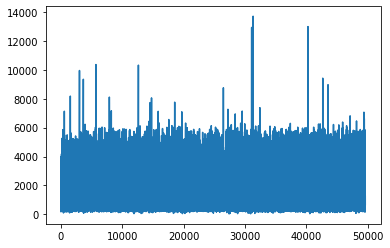

In [ ]:
df['review'].str.len().plot();

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 774.8+ KB


In [ ]:
stopwords = list(set(nltk.corpus.stopwords.words("english")))
for rm in ["didn't", "don't", "doesn't", "wasn't", "weren't", "aren't", "won't", 'no', "isn't"]: stopwords.remove(rm)

In [ ]:
def sentence_cleaner(text):
    text = text.lower()
    text = re.sub('<br /><br />_+<br /><br />','. ', text)
    text = text.replace("<br /><br />",". ")
    text = re.sub(r'\.+','.',text)
    text = re.sub(r'no+[so]o','no', text)
    text = re.sub(r's+t+u+p+i+d','stupid', text)
    text = re.sub(r'ter+i+ble','terrible', text)
    text = re.sub(r'bo+r+in+g','boring',text)
    text = re.sub(r'goo+d','good',text)
    text = re.sub(r'wo+nderful','wonderful',text)
    text = re.sub(r'sup[eu]+r+b','superb',text)
    text = re.sub(r'lo+v+e','love',text)
    text = re.sub(r'na+h','no',text)   
    text = re.sub(r'shi+t+y','shit',text)
    text = re.sub(r'we+ll','well',text)
    
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    text = re.sub('www.(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
    text = re.sub('\d+','', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.replace("scheduleservlet?action_detail=detail&focus_id=598947","")

    longestwords_dict = {"It'saboutaguylookingforthewomanwhosavedhisgrandpafromtheNazis".lower(): "It's about a guy looking for the woman who saved his grandpa from the Nazis".lower(),
                     "LoveHateDreamsLifeWorkPlayFriends".lower():"Love Hate Dreams Life Work Play Friends".lower(),
                     "anothermaniacherewegoagain":"another maniac here we go again",
                     "heyijustleftmycoatbehind":"hey i just leftmy coat behind ",
                     "brianjonestownmassacre":"brian jonestown massacre",
                     "cough2Fast2Furiouscough".lower():"cough 2 Fast 2 Furious cough".lower(),
                     "realityshowfictionnal":"reality show fictional",
                     "hongkongmovieshootouts":"hongkong movie shootouts",
                     "worlddestructionthemes":"world destruction themes",
                     "redoredoredocopycopycopy":"redo redo redo copy copy copy",
                     "whateverherlastnameis":"what ever her last name is",
                     "specialagentfoxmulder":"special agent fox mulder",
                     "ammmmmbbbererrrrrrrrrgerrrrrrrssss":"amber gas"}

    for i,j in longestwords_dict.items(): text.replace(i,j)

    return text

def token_cleaner(tokens):
    scrap = [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","`","''","``","\"","“"," ","'m","'no","***","--","[","]","{","}","~","@","#","$","%","^","*","/","<",">","+","-","="]
    new_tokens = []
    for token in tokens:
        token = token.strip("_")
        token = token.lstrip("'")
        token = token.lstrip("-")

        if (token.replace(" ","").isdecimal()) and (token.count("_") == len(token)): token = ""

        if len(token) and (token not in scrap) and (token not in stopwords): new_tokens.append(token)
    return new_tokens


In [ ]:
df['review'] = df['review'].apply(lambda x: sentence_cleaner(x))

In [ ]:
df['review'] = df['review'].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
df['review'] = df['review'].apply(lambda x: token_cleaner(x))

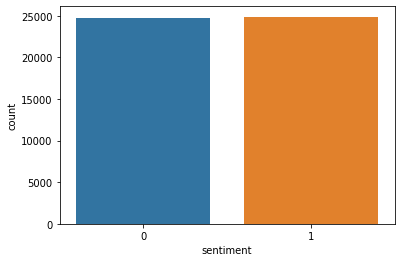

In [ ]:
sns.countplot(x = 'sentiment', data = df);

# Skip Gram Model

In [ ]:
word_list = []
for sent in df['review'].values: word_list.extend(sent)

print('Total no. of unique words in the corpus: ', len(set(word_list)))

Total no. of unique words in the corpus:  162214


In [ ]:
vocab_cnt = Counter()
vocab_cnt.update(word_list)
vocab_cnt = Counter({w:c for w,c in vocab_cnt.items() if c > 5})

print("Total unique words after ignoring words occuring less than 6 times:",len(vocab_cnt))

Total unique words after ignoring words occuring less than 6 times: 38206


In [ ]:
word_list = list(vocab_cnt.keys())
word_list.sort()
vocab_size = len(word_list)

In [ ]:
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_list)

skip_grams = []

for sent in  df['review'].values:
    for i in range(1, len(sent)-1):     
        try:
            target = word_dict[sent[i]]         
            context = [word_dict[sent[i - 1]], word_dict[sent[i + 1]]]          #window_size = 1
            for w in context:
                skip_grams.append([target, w])
        except: continue

In [ ]:
print('Total no. of skip grams: ',len(skip_grams))

Total no. of skip grams:  10612482


In [ ]:
np.save('/content/gdrive/My Drive/Colab Notebooks/Saved_models/skip_grams.npy',skip_grams)

In [ ]:
embed_lr = 0.001
embed_batch_size = 4096
embed_dimension = 200
tot_epochs =  1000

In [ ]:
@torch.no_grad()
def prepare_batch_from_skip_grams(skip_grams, batch_size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)
    for i in random_index:
        input_temp = [0]*vocab_size
        input_temp[skip_grams[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(skip_grams[i][1])  # context word
    return np.array(random_inputs), np.array(random_labels)


In [ ]:
class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(vocab_size, embed_dimension,bias=False)
        self.linear2 = nn.Linear(embed_dimension, vocab_size,bias=False)

    def forward(self,x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

In [ ]:
skip_gram_model = SkipGram().to(device)
model_save_name = 'LSTM_sentiment_embeds.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/Saved_models/{model_save_name}"
skip_gram_model.load_state_dict(torch.load(path, map_location=device),strict=True)
skip_gram_model.to(device)
skip_gram_model.train()

SkipGram(
  (linear1): Linear(in_features=38206, out_features=200, bias=False)
  (linear2): Linear(in_features=200, out_features=38206, bias=False)
)

In [ ]:
embed_lr = 0.001
tot_epochs =  1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(skip_gram_model.parameters(), lr=embed_lr)

model_save_name = 'LSTM_sentiment_embeds.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/Saved_models/{model_save_name}"

skip_gram_model.train()
for epoch in tqdm(range(tot_epochs)):

    previous_epoch_timestamp = time()
    inputs,labels = prepare_batch_from_skip_grams(skip_grams, embed_batch_size)
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels).long().to(device)

    preds = skip_gram_model(inputs)
    loss = criterion(preds, labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

    if epoch % 10 == 9:
        print('Epoch: %d, loss: %.6f' %(epoch + 1, loss),f', time took for this epoch: {time()-previous_epoch_timestamp}')

    if epoch%250 == 0: torch.save(skip_gram_model.state_dict(),path)

torch.cuda.empty_cache()
torch.save(skip_gram_model.state_dict(),path)

Epoch: 10, loss: 19.679464, train_acc: 0.015869, lr: 0.010000 , time took for this epoch: 20.277894735336304
Epoch: 20, loss: 18.965954, train_acc: 0.017822, lr: 0.010000 , time took for this epoch: 20.88726234436035
Epoch: 30, loss: 17.931618, train_acc: 0.020264, lr: 0.010000 , time took for this epoch: 20.761378526687622
Epoch: 40, loss: 17.234312, train_acc: 0.024170, lr: 0.010000 , time took for this epoch: 20.77065873146057
Epoch: 50, loss: 17.497650, train_acc: 0.027100, lr: 0.010000 , time took for this epoch: 20.861411571502686
Epoch: 60, loss: 16.743546, train_acc: 0.022949, lr: 0.010000 , time took for this epoch: 20.6287260055542
Epoch: 70, loss: 16.266762, train_acc: 0.023438, lr: 0.010000 , time took for this epoch: 20.298937559127808
Epoch: 80, loss: 15.247561, train_acc: 0.025391, lr: 0.010000 , time took for this epoch: 20.293034076690674
Epoch: 90, loss: 15.598787, train_acc: 0.026367, lr: 0.010000 , time took for this epoch: 20.939169883728027
Epoch: 100, loss: 15.08

In [ ]:
torch.cuda.empty_cache()
torch.save(skip_gram_model.state_dict(),path)

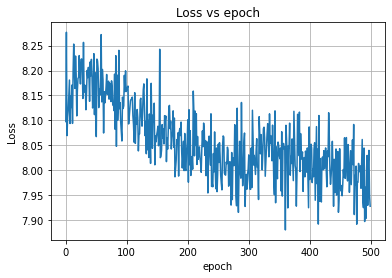

In [ ]:
plt.plot(np.arange(0,len(losses)),losses)
plt.title('Loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid(1)
plt.show()

# Trained Embeddings

In [ ]:
skip_gram_model.eval()
w1 = skip_gram_model.linear1.weight.detach().T.cpu().numpy()
w2 = skip_gram_model.linear2.weight.detach().cpu().numpy()

trainedword2vec = (w1 + w2)/2
del w1, w2
gc.collect()

228

In [ ]:
trainedword2vec.shape

(38206, 200)

# Tokenizing

In [ ]:
review_lengths = [len(x) for x in df['review']]

In [ ]:
pd.DataFrame(review_lengths).describe()

,0
count,49582.000000
mean,119.558892
std,90.023226
min,3.000000
25%,64.000000
50%,89.000000
75%,145.000000
max,1430.000000


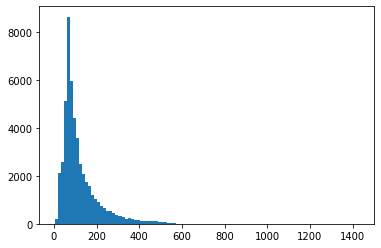

In [ ]:
plt.hist(review_lengths, bins = 100);

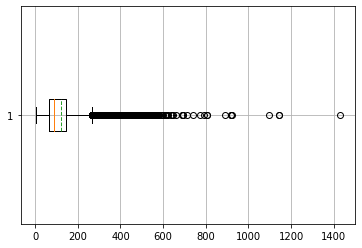

In [ ]:
plt.grid(1)
plt.boxplot(review_lengths, vert=False,meanline=True,showmeans=True);

Since, most of the sentences falls under length of 200 words, we consider max sentence length as 200 to pad or truncate reviews.

In [ ]:
def pad_trucate(sentence,max_length=200):
    if len(sentence) > max_length:
        return sentence[:max_length]
    else:
        for i in range(max_length-len(sentence)):
            sentence.append("<PAD>")
        return sentence

In [ ]:
df['review'] = df['review'].apply(lambda x: pad_trucate(x))

In [ ]:
pd.DataFrame([len(x) for x in df['review']]).describe()

,0
count,49582.0
mean,200.0
std,0.0
min,200.0
25%,200.0
50%,200.0
75%,200.0
max,200.0


# Splitting data into train and test data sets

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df['review'].values,df['sentiment'].values,stratify=df['sentiment'].values, test_size=0.15)   #15% of data as test data

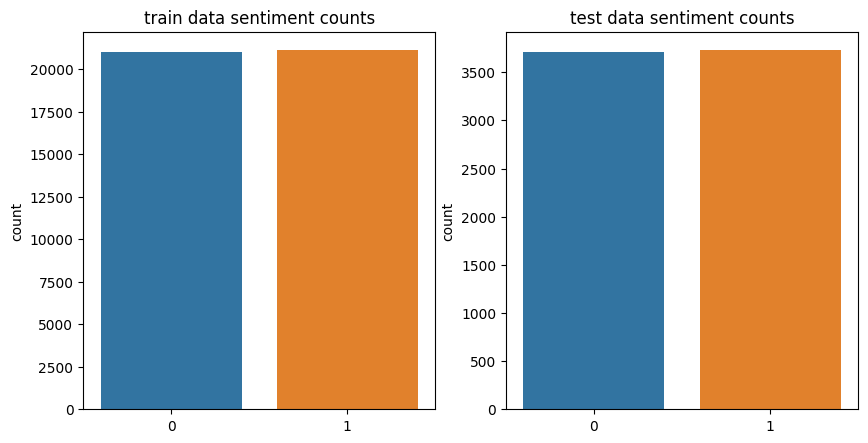

In [ ]:
plt.figure(figsize= (10,5), dpi= 100)
plt.tight_layout()

plt.subplot(1,2,1)
plt.title('train data sentiment counts')
sns.countplot(y_train);

plt.subplot(1,2,2)
plt.title('test data sentiment counts')
sns.countplot(y_test);

In [ ]:
*x_train.shape, *x_test.shape

(42144, 7438)

# Sentiment Analysis with LSTM model

In [ ]:
embed_dimension = 200
lstm_hidden_out = 50
no_of_classes = 2

In [ ]:
@torch.no_grad()
def prepare_embeddings_for_batch(corpus, labels, word_dict, trainedword2vec, lstm_batch_size, epoch):
    in_batch = []
    label_batch = []

    indexes = range(epoch*lstm_batch_size,(epoch+1)*lstm_batch_size)
    indexes = [r if r < len(corpus) else (r % len(corpus)) for r in indexes]

    for i in indexes:
        temp = []
        for token in corpus[i]:
            token_found = False
            word_index = 0
            try:
                word_index = word_dict[token]
                token_found = True
            except: token_found = False
            if token_found:
                temp.append(trainedword2vec[word_index])
            else: temp.append([0]*embed_dimension)
        in_batch.append(temp)
        label_batch.append(labels[i])
    return np.array(in_batch), np.array(label_batch)

In [ ]:
class LSTM_Sentiment_Analiser(nn.Module):
    def __init__(self):
        super(LSTM_Sentiment_Analiser, self).__init__()
        self.lstm = nn.LSTM(embed_dimension, lstm_hidden_out, num_layers=2, batch_first =True, dropout=0.2)
        self.linear = nn.Linear(lstm_hidden_out, no_of_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
net = LSTM_Sentiment_Analiser().to(device)
model_save_name = 'LSTM_sentiment_params.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/Saved_models/{model_save_name}"
net.load_state_dict(torch.load(path, map_location=device),strict=True)
net.to(device)
net.train()

LSTM_Sentiment_Analiser(
  (lstm): LSTM(200, 50, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
lstm_batch_size = 256
lstm_lr = 0.00001
tot_epochs =  10000
losses = []
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=lstm_lr)
model_save_name = 'LSTM_sentiment_params.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/Saved_models/{model_save_name}"
net.train()
for epoch in tqdm(range(tot_epochs)):
    if epoch%320 == 0 and epoch:
        if lstm_lr <= 0.000001: lstm_lr = 0.000001
        else: lstm_lr *= 0.95
        optimizer = optim.Adam(net.parameters(), lr=lstm_lr)

    previous_epoch_timestamp = time()
    inputs, labels = prepare_embeddings_for_batch(x_train, y_train, word_dict, trainedword2vec, lstm_batch_size, epoch)
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels).view(-1).to(device)

    preds =net(inputs)
    loss = criterion(preds, labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

    if epoch%160 == 159:
        acc = accuracy_score(torch.max(preds,1)[1].cpu().numpy(), labels.cpu().numpy())
        print('Epoch: %d, loss: %.6f, train_acc: %.6f, lr: %.6f'%(epoch + 1, loss.item(), acc, lstm_lr),f', time took for this epoch: {(time()-previous_epoch_timestamp):.6f}')

    if epoch%500 == 0: torch.save(net.state_dict(),path)

torch.cuda.empty_cache()
torch.save(net.state_dict(),path)

Epoch: 160, loss: 0.418715, train_acc: 0.796875, lr: 0.000010 , time took for this epoch: 0.557684
Epoch: 320, loss: 0.328333, train_acc: 0.882812, lr: 0.000010 , time took for this epoch: 0.540524
Epoch: 480, loss: 0.428008, train_acc: 0.824219, lr: 0.000010 , time took for this epoch: 0.547142
Epoch: 640, loss: 0.404767, train_acc: 0.800781, lr: 0.000010 , time took for this epoch: 0.613017
Epoch: 800, loss: 0.342930, train_acc: 0.851562, lr: 0.000009 , time took for this epoch: 0.582511
Epoch: 960, loss: 0.343283, train_acc: 0.863281, lr: 0.000009 , time took for this epoch: 0.543780
Epoch: 1120, loss: 0.441111, train_acc: 0.789062, lr: 0.000009 , time took for this epoch: 0.584797
Epoch: 1280, loss: 0.382960, train_acc: 0.835938, lr: 0.000009 , time took for this epoch: 0.583856
Epoch: 1440, loss: 0.318757, train_acc: 0.875000, lr: 0.000008 , time took for this epoch: 0.584506
Epoch: 1600, loss: 0.373877, train_acc: 0.847656, lr: 0.000008 , time took for this epoch: 0.593933
Epoch:

In [ ]:
torch.cuda.empty_cache()
model_save_name = 'LSTM_sentiment_params.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/Saved_models/{model_save_name}"
torch.save(net.state_dict(),path)

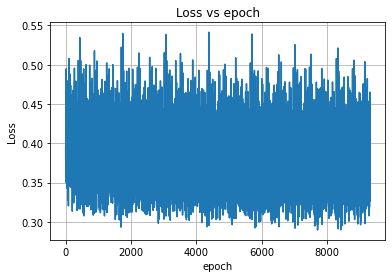

In [ ]:
plt.plot(np.arange(0,len(losses)),losses)
plt.title('Loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid(1)
plt.show()

# Evaluating the Network

In [ ]:
@torch.no_grad()
def Evaluating_the_net():
    all_test_preds = []
    all_test_labels= []
    net.eval()

    for i in range(2):
        inputs, labels = prepare_embeddings_for_batch(x_test, y_test, word_dict, trainedword2vec, 3719, i)
        inputs = torch.from_numpy(inputs).float().to(device)

        preds = torch.max(net(inputs), 1)[1]
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels)
    
    print("Total test accuracy: ",accuracy_score(all_test_preds, all_test_labels))
    print(classification_report(all_test_labels, all_test_preds))

In [ ]:
Evaluating_the_net()

Total test accuracy:  0.8480774401720893
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3705
           1       0.86      0.84      0.85      3733

    accuracy                           0.85      7438
   macro avg       0.85      0.85      0.85      7438
weighted avg       0.85      0.85      0.85      7438

